# Регрессионный анализ для предсказания CC50

В этом ноутбуке мы построим несколько моделей машинного обучения для предсказания значения CC50 на основе характеристик химических соединений.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

In [2]:
# Загрузка данных
df = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx', sheet_name='Sheet1')

## Подготовка данных

In [3]:
# Целевая переменная
y = np.log1p(df['CC50, mM'])  # Логарифмическое преобразование

# Признаки
X = df.drop(['IC50, mM', 'CC50, mM', 'SI'], axis=1)

# Удаление константных столбцов
constant_columns = [col for col in X.columns if X[col].nunique() == 1]
X = X.drop(constant_columns, axis=1)

# Заполнение пропущенных значений
X = X.fillna(X.median())

# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Базовые модели регрессии

In [4]:
# Список моделей для сравнения
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(random_state=42)),
    ('Lasso Regression', Lasso(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('LightGBM', LGBMRegressor(random_state=42)),
    ('CatBoost', CatBoostRegressor(random_state=42, verbose=False))
]

In [5]:
# Оценка моделей с помощью кросс-валидации
results = []
names = []
for name, model in models:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    results.append(rmse_scores)
    names.append(name)
    print(f"{name}: Средний RMSE = {rmse_scores.mean():.4f}, STD = {rmse_scores.std():.4f}")

Linear Regression: Средний RMSE = 376.3636, STD = 743.7025
Ridge Regression: Средний RMSE = 2.2685, STD = 1.7214
Lasso Regression: Средний RMSE = 1.6059, STD = 0.0561
Random Forest: Средний RMSE = 1.1463, STD = 0.0893
Gradient Boosting: Средний RMSE = 1.1826, STD = 0.0710
XGBoost: Средний RMSE = 1.2590, STD = 0.1027
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15239
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 168
[LightGBM] [Info] Start training from score 5.531283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

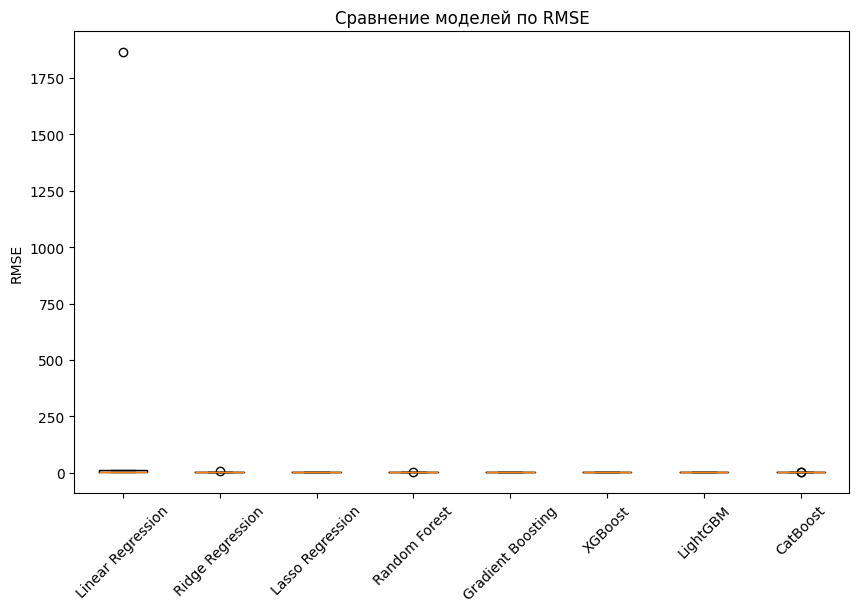

In [6]:
# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.boxplot(results, labels=names)
plt.xticks(rotation=45)
plt.title('Сравнение моделей по RMSE')
plt.ylabel('RMSE')
plt.show()

## Настройка гиперпараметров для лучших моделей

In [7]:
# Настройка Random Forest
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Лучшие параметры для Random Forest:", grid_rf.best_params_)
print("Лучший RMSE:", np.sqrt(-grid_rf.best_score_))

Лучшие параметры для Random Forest: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Лучший RMSE: 1.1461431344800177


In [8]:
# Настройка XGBoost
param_grid_xgb = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6],
    'model__learning_rate': [0.01, 0.1]
}

pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(random_state=42))
])

grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Лучшие параметры для XGBoost:", grid_xgb.best_params_)
print("Лучший RMSE:", np.sqrt(-grid_xgb.best_score_))

Лучшие параметры для XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Лучший RMSE: 1.1837690196212858


In [9]:
# Настройка LightGBM
param_grid_lgb = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6],
    'model__learning_rate': [0.01, 0.1]
}

pipeline_lgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMRegressor(random_state=42))
])

grid_lgb = GridSearchCV(pipeline_lgb, param_grid_lgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_lgb.fit(X_train, y_train)

print("Лучшие параметры для LightGBM:", grid_lgb.best_params_)
print("Лучший RMSE:", np.sqrt(-grid_lgb.best_score_))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 169
[LightGBM] [Info] Start training from score 5.538760
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

## Оценка лучшей модели на тестовых данных

In [10]:
# Лучшая модель - XGBoost с подобранными параметрами
best_model = grid_xgb.best_estimator_

# Предсказания на тестовых данных
y_pred = best_model.predict(X_test)

# Оценка качества
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Результаты на тестовых данных:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.4f}")

Результаты на тестовых данных:
MSE: 1.2078
RMSE: 1.0990
R2: 0.4689
MAE: 0.8051


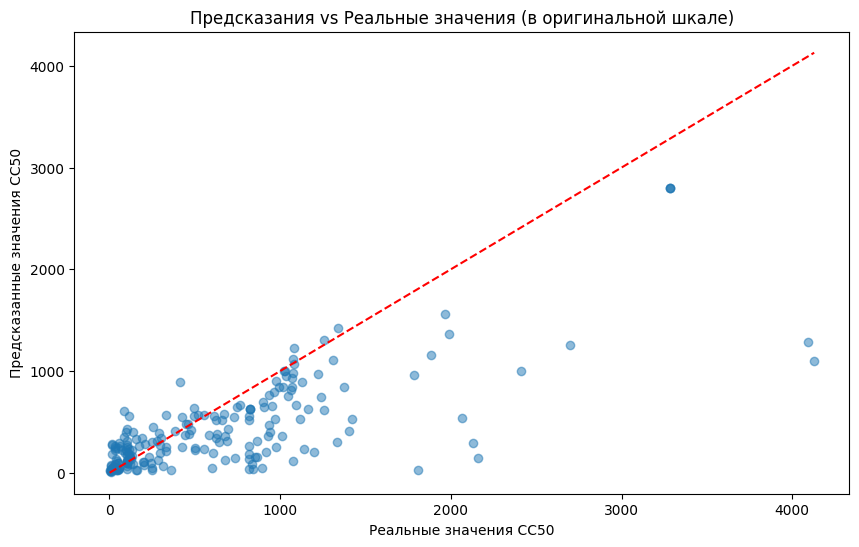

In [11]:
# Визуализация предсказаний vs реальные значения
plt.figure(figsize=(10, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.5)
plt.plot([min(np.expm1(y_test)), max(np.expm1(y_test))], [min(np.expm1(y_test)), max(np.expm1(y_test))], '--r')
plt.xlabel('Реальные значения CC50')
plt.ylabel('Предсказанные значения CC50')
plt.title('Предсказания vs Реальные значения (в оригинальной шкале)')
plt.show()

## Анализ важности признаков

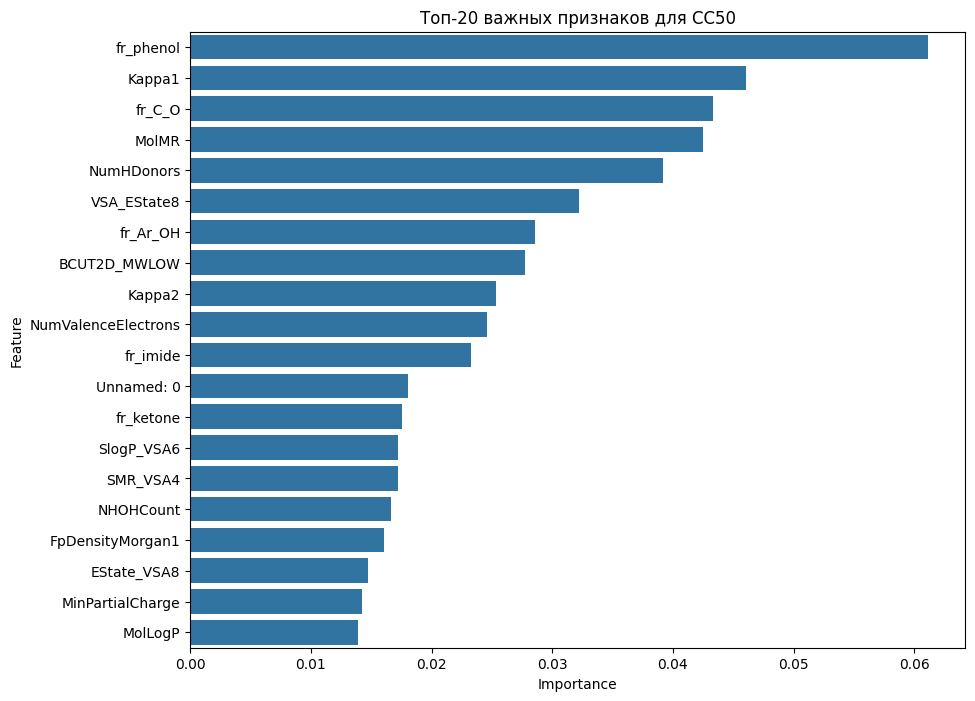

In [12]:
# Получение важности признаков из лучшей модели
feature_importance = best_model.named_steps['model'].feature_importances_

# Создание DataFrame для визуализации
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Топ-20 важных признаков
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Топ-20 важных признаков для CC50')
plt.show()

In [13]:
importance_df.head(20)

,Feature,Importance
177,fr_phenol,0.061169
43,Kappa1,0.046060
133,fr_C_O,0.043328
122,MolMR,0.042498
114,NumHDonors,0.039203
101,VSA_EState8,0.032206
130,fr_Ar_OH,0.028577
19,BCUT2D_MWLOW,0.027758
44,Kappa2,0.025313
10,NumValenceElectrons,0.024619


## Выводы

1. Лучшей моделью для предсказания CC50 оказался XGBoost с RMSE = 1.18 на кросс-валидации и RMSE = 1.09 на тестовых данных
2. Наиболее важными признаками для предсказания CC50 являются:
   - fr_phenol
   - Kappa1
   - fr_C_O
   - MolMR
   - NumHDonors
   - VSA_EState8
   - fr_Ar_OH
   - BCUT2D_MWLOW

   Таким образом, токсичность вакцины зависит от структурных фрагментов (фенолы: fr_phenol, fr_C_O, fr_Ar_OH), структуры и формы молекулы (Kappa1), электронных и поверхностных свойств (VSA, BCUT, MolMR), способности к образованию водородных связей (NumHDonors)

3. Модель объясняет около 47% дисперсии данных (R2 = 0.47)
4. Для дальнейшего улучшения модели можно:
   - Провести более тщательный подбор гиперпараметров
   - Использовать ансамбли моделей
   - Применить методы уменьшения размерности